[link to db](http://yuhang.rsise.anu.edu.au/)

[cnn/nn](https://medium.com/swlh/price-tag-detector-multi-digit-classification-using-tensorflow-object-detection-and-svhn-38506705bcf2)



when you want to rename imges or files from 0 to N
```ls -v | cat -n | while read n f; do mv -n "$f" "$n.ext"; done``` 


In [1]:
import numpy as np

In [2]:
# data augmentation
urlDb = '/home/henri/Desktop/roboflow'

In [3]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ia.seed(1)

image = ia.quokka(size=(256, 256))
bbs = BoundingBoxesOnImage([
    BoundingBox(x1=65, y1=100, x2=200, y2=150),
    BoundingBox(x1=150, y1=80, x2=200, y2=130)
], shape=image.shape)

#setting the pipeline
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])
print(type(image),type(bbs))
print(bbs)
# Augment BBs and images.
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(image, size=2)
image_after = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])

Populating the interactive namespace from numpy and matplotlib
<class 'numpy.ndarray'> <class 'imgaug.augmentables.bbs.BoundingBoxesOnImage'>
BoundingBoxesOnImage([BoundingBox(x1=65.0000, y1=100.0000, x2=200.0000, y2=150.0000, label=None), BoundingBox(x1=150.0000, y1=80.0000, x2=200.0000, y2=130.0000, label=None)], shape=(256, 256, 3))
BB 0: (65.0000, 100.0000, 200.0000, 150.0000) -> (132.1574, 172.0700, 208.9629, 200.5164)
BB 1: (150.0000, 80.0000, 200.0000, 130.0000) -> (180.5164, 160.6914, 208.9629, 189.1378)


In [4]:
type(image_before)

numpy.ndarray

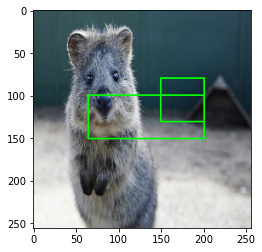

In [5]:
imgplot = plt.imshow(image_before)
plt.show()

Images loading,conversion and saving fucntions

In [6]:
import PIL
def loadImgToArray(url,info=False):
    """
    take the url and return the image (PIL format) as a numpy Array
    """
    image = PIL.Image.open(url)
    imgArray = np.asarray(image)
    if info:
        print(f'From: {type(image)}, Size: {image.size}, Mode: {image.mode}\nTo: {type(imgArray)}, shape: {imgArray.shape}')
    
    return imgArray

In [7]:
def saveArrayToImg(url,npArray,info=False):
    """
    Takes a numpy array and converts it 
    """
    image = PIL.Image.fromarray(npArray)
    if info:
        print(f'From: {type(npArray)}, shape: {npArray.shape}\nTo: {type(image)}, Size: {image.size}, Mode: {image.mode}')
    image.save(url)

In [8]:
# test
mainUrl = '/home/henri/Desktop/roboflow/'
testUrl = '/home/henri/Desktop/roboflow/quickTest/'

npArray = loadImgToArray(mainUrl+'136.jpg', info=True)
saveArrayToImg(testUrl+'136.jpg', npArray,info=True)

From: <class 'PIL.JpegImagePlugin.JpegImageFile'>, Size: (1000, 1627), Mode: RGB
To: <class 'numpy.ndarray'>, shape: (1627, 1000, 3)
From: <class 'numpy.ndarray'>, shape: (1627, 1000, 3)
To: <class 'PIL.Image.Image'>, Size: (1000, 1627), Mode: RGB


BBox loading and saving functions

In [9]:
from io import StringIO 
def loadingBBox(fileurl):
    """
    Assuming the data is in this format
    <object-class> <x> <y> <width> <height> 
    [1.      , 0.250126, 0.29366 , 0.471062, 0.410735]

    The boundary object
    """
    boxData = np.loadtxt(fileurl)
    data = boxData[:,1:]
    label = boxData[:,0:1]
    return [label, data]

In [10]:
def saveBBox(fileurl, label, data):
    """
    save numpy array in this format
    1 0.250126 0.293660 0.471062 0.410735
    delimiter is a space 
    """
    fullAnnotation = np.column_stack([label,data])
    np.savetxt(fileurl, fullAnnotation,fmt='%f', delimiter=' ')

In [11]:
def imageBoxFit(data,npArray,operation):
    """
    type = ['load','save]
    since our yolo annotations comes in this format we need to resize to fit the image shape(x,y)
    x1=0.250126 y1=0.293660 x2=0.471062 y2=0.410735
    <object-class> <x> <y> <width> <height> 
    """
    if operation == 'load':
        data[:,0:3:2] = data[:,0:3:2]*npArray.shape[1] # x1,x2 columns
        data[:,1:4:2] = data[:,1:4:2]*npArray.shape[0] # y1,y2 columns

        
        return data
    if operation == 'save':
        data[:,0:3:2] = data[:,0:3:2]/npArray.shape[1] 
        data[:,1:4:2] = data[:,1:4:2]/npArray.shape[0] 
        return data

In [57]:
# test (loading boxes)
mainUrl = '/home/henri/Desktop/roboflow/quickTest/'
testUrl = '/home/henri/Desktop/roboflow/quickTest/'
l,d = loadingBBox(mainUrl+'136.txt')
saveBBox(testUrl+'136.txt',l,d)
# test (confirming boxes width)

In [58]:
d

array([[0.508   , 0.753859, 0.888   , 0.141348],
       [0.5135  , 0.116572, 0.837   , 0.137287]])

In [14]:
imageBoxFit(d,npArray,'load')

array([[ 135.      ,  295.500621,  120.      ,  133.000742],
       [ 842.5     ,  125.500272,  121.      ,  133.000742],
       [ 549.      ,  654.000309,  120.      ,  133.99972 ],
       [ 120.      ,  706.500345,  120.      ,  133.000742],
       [ 705.5     ,  931.000313,  121.      ,  133.99972 ],
       [ 397.      ,  951.500513,  120.      ,  133.000742],
       [ 115.      ,  981.500766,  120.      ,  133.000742],
       [ 110.5     , 1289.000512,  119.      ,  133.99972 ],
       [ 432.      , 1279.500459,  120.      ,  133.000742],
       [ 715.5     , 1292.0007  ,  121.      ,  133.99972 ],
       [ 245.5     ,  400.500693,  391.      ,  402.999765],
       [ 520.      , 1389.500302,  296.      ,  329.000551],
       [ 245.      ,  771.500622,  360.      ,  299.000298],
       [ 710.5     ,  692.000521,  531.      ,  375.9997  ],
       [ 715.5     ,  334.000322,  481.      ,  429.99983 ],
       [ 802.5     , 1376.500572,  297.      ,  329.000551],
       [ 214.5     , 106

Change to 

In [15]:
image = loadImgToArray(mainUrl+'2.jpg')
label,data = loadingBBox(mainUrl+'2.txt')
data = imageBoxFit(data,image,'load')
bbs = list()
for box in data:
    x1,y1,x2,y2 = box
    bbs.append(BoundingBox(x1, y1, x2, y2))
bbs = BoundingBoxesOnImage(bbs,shape=image.shape)

In [16]:
#setting the pipeline
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])
print(type(image),type(bbs))

<class 'numpy.ndarray'> <class 'imgaug.augmentables.bbs.BoundingBoxesOnImage'>


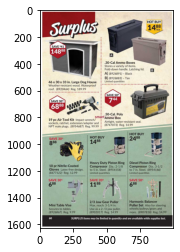

In [17]:
imgplot = plt.imshow(image)
plt.show()

In [18]:
# Augment BBs and images.
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(image, size=2)
image_after = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])

BB 0: (120.0000, 133.0007, 135.0000, 295.5006) -> (318.2588, 476.4086, 327.0117, 571.2321)
BB 1: (121.0000, 125.5003, 842.5000, 133.0007) -> (318.8423, 472.0319, 739.8589, 476.4086)
BB 2: (120.0000, 133.9997, 549.0000, 654.0003) -> (318.2588, 476.9915, 568.5930, 780.4272)
BB 3: (120.0000, 133.0007, 120.0000, 706.5003) -> (318.2588, 476.4086, 318.2588, 811.0626)
BB 4: (121.0000, 133.9997, 705.5000, 931.0003) -> (318.8423, 476.9915, 659.9153, 942.0649)
BB 5: (120.0000, 133.0007, 397.0000, 951.5005) -> (318.2588, 476.4086, 479.8965, 954.0273)
BB 6: (115.0000, 133.0007, 120.0000, 981.5008) -> (315.3411, 476.4086, 318.2588, 971.5334)
BB 7: (110.5000, 133.9997, 119.0000, 1289.0005) -> (312.7152, 476.9915, 317.6752, 1150.9686)
BB 8: (120.0000, 133.0007, 432.0000, 1279.5005) -> (318.2588, 476.4086, 500.3200, 1145.4250)
BB 9: (121.0000, 133.9997, 715.5000, 1292.0007) -> (318.8423, 476.9915, 665.7506, 1152.7194)
BB 10: (245.5000, 400.5007, 391.0000, 402.9998) -> (391.4917, 632.5027, 476.3953, 63

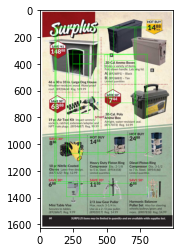

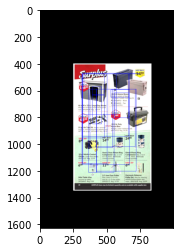

In [19]:
imgplot = plt.imshow(image_before)
plt.show()
imgplot = plt.imshow(image_after)
plt.show()

In [61]:
BoundingBox(H=100,W=200,C=(12,13))

TypeError: __init__() got an unexpected keyword argument 'H'

In [60]:
# FOR FUCK SAKES, I HAVE TO FUCKING CONVERT THE BBoxes to Numpty array
# bbs use 2 system (x1,y1) and (x2,y2) which have to be unpackaged
help(BoundingBox)

=30, copy=True, raise_if_out_of_image=False)
 |      Draw a box showing the BB's label.
 |      
 |      The box is placed right above the BB's rectangle.
 |      
 |      Added in 0.4.0.
 |      
 |      Parameters
 |      ----------
 |      image : (H,W,C) ndarray
 |          The image onto which to draw the label.
 |          Currently expected to be ``uint8``.
 |      
 |      color : None or iterable of int, optional
 |          The color to use, corresponding to the channel layout of the
 |          image. Usually RGB. Text and background colors will be derived
 |          from this.
 |      
 |      color_text : None or iterable of int, optional
 |          The text color to use.
 |          If ``None``, derived from `color_bg`.
 |      
 |      color_bg : None or iterable of int, optional
 |          The background color of the label box.
 |          If ``None``, derived from `color`.
 |      
 |      alpha : float, optional
 |          The transparency of the drawn bounding bo

In [55]:
testUrl = '/home/henri/Desktop/roboflow/quickTest/'

saveArrayToImg(testUrl+'2test.jpg', image_aug,info=True) # def saveArrayToImg(url,npArray,info=False)
data = imageBoxFit(bbsArray,image_after,'save') # def imageBoxFit(data,npArray,operation)
saveBBox(testUrl+'2test.txt',label,data) #saveBBox(fileurl, label, data)

From: <class 'numpy.ndarray'>, shape: (1627, 1000, 3)
To: <class 'PIL.Image.Image'>, Size: (1000, 1627), Mode: RGB
